El conjunto de datos que vamos a usar corresponde al dataset de kaagle : DAta Breast Cancer. Son xxxx imagenes radiológicas clasificadas.......

Para la descarga vamos a hacer uso de la API de Kaagle, para poder reutilizar este notebook es necesario estar dado de alto en Kaagle y poder descargarse un token.

### **Imports**

In [1]:
! pip install keras 
! pip install tensorflow
! pip install tensorflow-addons

In [2]:
#from google.colab import files
#from google.colab import drive
#from glob import glob


# comunes
import os
import keras
import numpy as np
import pandas as pd
import random
import cv2
import tensorflow as tf
import tensorflow.image as tfi
import tensorflow_addons as tfa


from tqdm import tqdm
from mpl_toolkits.axes_grid1 import ImageGrid

# Data
from tensorflow.keras.utils import load_img,img_to_array
#from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

### **Funciones y constantes**

Activamos la unidad de drive para usarla en Colab y no tener que efectuar todos los pasos anteriores de descarga y descompresión cada vez

In [3]:
#drive.mount('/content/drive/')

In [4]:
#google colab
#dataset_dir = '/content/drive/My Drive/Colab Notebooks/db/cbis-ddsm'

#local
dataset_dir = '/home/fjcorrales/Master Ciencia de datos/TFM/dataset/archive'

#Cargamos los datasets

df = pd.read_csv(dataset_dir + '/dicom.csv')
df_calc_train = pd.read_csv(dataset_dir + '/calc_train.csv')
df_calc_test = pd.read_csv(dataset_dir + '/calc_test.csv')
df_mass_train = pd.read_csv(dataset_dir + '/mass_train.csv')
df_mass_test = pd.read_csv(dataset_dir + '/mass_test.csv')


# Mass y calc train
X_train = []
y_train = []

for i in range(len(df_mass_train)):
    img_cropped = cv2.imread(df_mass_train.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (256, 256), interpolation = cv2.INTER_LINEAR)
    X_train.append(n_img_size)
    if df_mass_train.loc[i, 'pathology']=='BENIGN':
      y_train.append(0)
    else:
      y_train.append(1)

for i in range(len(df_calc_train)):
    img_cropped = cv2.imread(df_calc_train.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (256, 256), interpolation = cv2.INTER_LINEAR)
    X_train.append(n_img_size)
    if df_calc_train.loc[i, 'pathology']=='BENIGN':
      y_train.append(0)
    else:
      y_train.append(1)


# Mass y calc  test
X_test = []
y_test = []

for i in range(len(df_mass_test)):
    img_cropped = cv2.imread(df_mass_test.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (256, 256), interpolation = cv2.INTER_LINEAR)
    X_test.append(n_img_size)
    if df_mass_test.loc[i, 'pathology']=='BENIGN':
      y_test.append(0)
    else:
      y_test.append(1)

for i in range(len(df_calc_test)):
    img_cropped = cv2.imread(df_calc_test.loc[i, 'cropped_image_path'],cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(img_cropped, (256, 256), interpolation = cv2.INTER_LINEAR)
    X_test.append(n_img_size)
    if df_calc_test.loc[i, 'pathology']=='BENIGN':
      y_test.append(0)
    else:
      y_test.append(1)






In [5]:

X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)


X_train = X_train/255
X_test  = X_test/255

y_train.resize(y_train.shape[0],1)
y_test.resize(y_test.shape[0],1)



print(f"x_train shape: {X_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {X_test.shape} - y_test shape: {y_test.shape}")

#y_train_calc = to_categorical(y_train_calc, 2)
#y_test_calc = to_categorical(y_test_calc, 2)



x_train shape: (2862, 256, 256, 3) - y_train shape: (2862, 1)
x_test shape: (704, 256, 256, 3) - y_test shape: (704, 1)


# Configuramos los hiperparametros del modelo ViT

In [6]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 50
image_size = 256  # We'll resize input images to this size
patch_size = 32  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

num_classes = 2
input_shape = (256, 256, 3)

# Usamos data augmentation

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),         
        layers.RandomBrightness(0.1, value_range=(0.0, 1.0)),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Implementamos multilayer perceptron (MLP)

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Implementamos la creacion de patches como una capa

In [9]:

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Probamos como se ven los patches con una imagen

Image size: 256 X 256
Patch size: 32 X 32
Patches per image: 64
Elements per patch: 3072


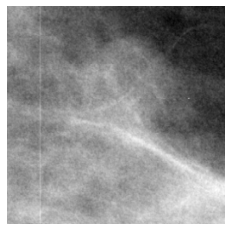

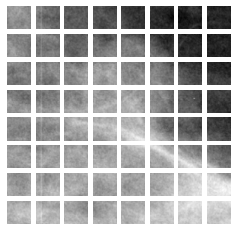

In [10]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

# Implementamos la capa de encoding

La capa PatchEncoder transformará linealmente un parche al proyectarlo en un vector de tamaño projection_dim. Además, agrega una posición de aprendizaje incrustada en el vector proyectado.

In [11]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Construimos el model Vision Transformer (ViT)
El modelo ViT consta de varios bloques Transformer, que utilizan la capa Layers.MultiHeadAttention como mecanismo de autoatención aplicado a la secuencia de parches. Los bloques Transformer producen un tensor [batch_size, num_patches,projection_dim], que se procesa a través de un cabezal clasificador con softmax para producir la salida final de probabilidades de clase.

A diferencia de la técnica descrita en el documento, que antepone una incrustación aprendible a la secuencia de parches codificados para que sirva como representación de la imagen, todas las salidas del bloque Transformer final se remodelan con capas.Flatten() y se utilizan como entrada de representación de imagen para la cabeza del clasificador. Tenga en cuenta que la capa Layers.GlobalAveragePooling1D también podría usarse para agregar las salidas del bloque Transformer, especialmente cuando la cantidad de parches y las dimensiones de la proyección son grandes.
Compilar, entrenar y evaluar el modo.

In [12]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


# Compilamos, entrenamos y evaluamos el modelo

In [13]:
def run_vit(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        #validation_split=0.1,
        validation_data=(X_test, y_test),
        callbacks=[checkpoint_callback],
    )

    #model.load_weights(checkpoint_filepath)
    #_, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    #print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
vit_classifier.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 256, 256, 3)  7          ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 3072)   0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 64, 64)       200768      ['patches_1[0][0]']          

 eadAttention)                                                    'layer_normalization_2[0][0]']  
                                                                                                  
 add_2 (Add)                    (None, 64, 64)       0           ['multi_head_attention_1[0][0]', 
                                                                  'add_1[0][0]']                  
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 64, 64)      128         ['add_2[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_3 (Dense)                (None, 64, 128)      8320        ['layer_normalization_3[0][0]']  
                                                                                                  
 dropout_2

 dropout_9 (Dropout)            (None, 64, 64)       0           ['dense_10[0][0]']               
                                                                                                  
 add_9 (Add)                    (None, 64, 64)       0           ['dropout_9[0][0]',              
                                                                  'add_8[0][0]']                  
                                                                                                  
 layer_normalization_10 (LayerN  (None, 64, 64)      128         ['add_9[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_5 (MultiH  (None, 64, 64)      66368       ['layer_normalization_10[0][0]', 
 eadAttention)                                                    'layer_normalization_10[0][0]'] 
          

 dropout_17 (Dropout)           (None, 2048)         0           ['dense_17[0][0]']               
                                                                                                  
 dense_18 (Dense)               (None, 1024)         2098176     ['dropout_17[0][0]']             
                                                                                                  
 dropout_18 (Dropout)           (None, 1024)         0           ['dense_18[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 2)            2050        ['dropout_18[0][0]']             
                                                                                                  
Total params: 11,357,385
Trainable params: 11,357,378
Non-trainable params: 7
__________________________________________________________________________________________________


In [14]:
history = run_vit(vit_classifier)

Epoch 1/50
12/12 [==============================] - 64s 4s/step - loss: 2.8850 - accuracy: 0.5391 - top-5-accuracy: 1.0000 - val_loss: 1.4391 - val_accuracy: 0.4915 - val_top-5-accuracy: 1.0000
Epoch 2/50
12/12 [==============================] - 50s 4s/step - loss: 0.8380 - accuracy: 0.5454 - top-5-accuracy: 1.0000 - val_loss: 1.6569 - val_accuracy: 0.4886 - val_top-5-accuracy: 1.0000
Epoch 3/50
12/12 [==============================] - 48s 4s/step - loss: 0.7487 - accuracy: 0.5695 - top-5-accuracy: 1.0000 - val_loss: 1.5753 - val_accuracy: 0.4815 - val_top-5-accuracy: 1.0000
Epoch 4/50
12/12 [==============================] - 49s 4s/step - loss: 0.7127 - accuracy: 0.5590 - top-5-accuracy: 1.0000 - val_loss: 1.5079 - val_accuracy: 0.4801 - val_top-5-accuracy: 1.0000
Epoch 5/50
12/12 [==============================] - 51s 4s/step - loss: 0.6902 - accuracy: 0.5720 - top-5-accuracy: 1.0000 - val_loss: 1.4502 - val_accuracy: 0.4943 - val_top-5-accuracy: 1.0000
Epoch 6/50
12/12 [============

Epoch 21/50
12/12 [==============================] - 54s 5s/step - loss: 0.6581 - accuracy: 0.5947 - top-5-accuracy: 1.0000 - val_loss: 1.1636 - val_accuracy: 0.5099 - val_top-5-accuracy: 1.0000
Epoch 22/50
12/12 [==============================] - 52s 4s/step - loss: 0.6619 - accuracy: 0.5891 - top-5-accuracy: 1.0000 - val_loss: 1.0973 - val_accuracy: 0.4986 - val_top-5-accuracy: 1.0000
Epoch 23/50
12/12 [==============================] - 51s 4s/step - loss: 0.6580 - accuracy: 0.5835 - top-5-accuracy: 1.0000 - val_loss: 1.0736 - val_accuracy: 0.5114 - val_top-5-accuracy: 1.0000
Epoch 24/50
12/12 [==============================] - 51s 4s/step - loss: 0.6582 - accuracy: 0.5940 - top-5-accuracy: 1.0000 - val_loss: 1.0499 - val_accuracy: 0.4787 - val_top-5-accuracy: 1.0000
Epoch 25/50
12/12 [==============================] - 49s 4s/step - loss: 0.6510 - accuracy: 0.6031 - top-5-accuracy: 1.0000 - val_loss: 1.0645 - val_accuracy: 0.4929 - val_top-5-accuracy: 1.0000
Epoch 26/50
12/12 [======

In [15]:
def create_vit_classifier_with_data_augmentation():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model